In [1]:
%load_ext autoreload

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os

In [3]:
from lsst.sims.catalogs.measures.instance import InstanceCatalog

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [4]:
from lsst.sims.catUtils.mixins import CosmologyMixin
from lsst.sims.utils import ObservationMetaData
from lsst.sims.catUtils.utils import ObservationMetaDataGenerator

Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values


In [5]:

from lsst.sims.photUtils import BandpassDict

In [6]:
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [7]:
import seaborn as sns
sns.set()

axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.


In [8]:
import pandas as pd

In [9]:
degConv = np.array([1., 1./60., 1./3600.])
raConv = degConv / 24.0 * 360.
centralRA = np.dot(np.array([3., 32., 30]), raConv) #03h 32m 30s
centralDec = np.dot(np.array([-28, 6., 0.]), degConv)
patchRadius = 0.4 * np.sqrt(2) #np.dot(np.array([0.0, 10.0, 0.]), degConv)

In [10]:
area = np.pi * (0.4 * np.sqrt(2.))**2

In [11]:
factorLarger = area / 0.16 / 0.16; print(factorLarger)

39.2699081699


In [12]:
NumHighSNdesired = factorLarger * 100; print (NumHighSNdesired)

3926.99081699


In [13]:
print(centralRA, centralDec, patchRadius)

(53.125, -27.899999999999999, 0.56568542494923812)


In [14]:
TwinklesObsMetaData = ObservationMetaData(boundType='circle',pointingRA=centralRA,pointingDec=centralDec,
                                          boundLength=patchRadius, mjd=49540.0)

In [15]:
TwinklesObsMetaDataSmall = ObservationMetaData(boundType='box',pointingRA=centralRA,pointingDec=centralDec,
                                          boundLength=0.167, mjd=49540.0)

In [16]:
#The following is to get the object ids in the registry
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj

In [17]:
galaxyTiled  = GalaxyTileObj()

/usr/local/manual/anaconda/lib/python2.7/site-packages/sqlalchemy/dialects/mssql/base.py:1294: SAWarning: Did not recognize type 'geography' of column 'geopoint'
  return fn(*arg, **kw)


In [18]:
class galCopy(InstanceCatalog):
    column_outputs = ['galtileid', 'raJ2000', 'decJ2000', 'redshift', 'a_d', 'b_d', 'pa_disk']
    override_formats = {'raJ2000': '%8e', 'decJ2000': '%8e', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e'}

In [19]:
TwinklesSmall = galCopy(galaxyTiled, obs_metadata=TwinklesObsMetaDataSmall)

In [20]:
TwinklesSmall.write_catalog('twinklesSmall.dat')

In [21]:
TwinklesGalaxies = galCopy(galaxyTiled, obs_metadata=TwinklesObsMetaData)

In [22]:
TwinkSmallGalsdf = pd.read_csv('TwinklesSmall.dat', sep=',\s+', engine='python')
TwinkSmallGalsdf.rename(columns={'#galtileid':'galtileid'}, inplace=True)

In [23]:
TwinkSmallGalsdf.head()

,galtileid,raJ2000,decJ2000,redshift,a_d,b_d,pa_disk
0,60001273449,0.925114,-0.488649,1.2427,0.412423,0.337010,168.25060
1,60001087478,0.925112,-0.488676,0.5517,0.180704,0.070001,92.41676
2,60014187558,0.925132,-0.488662,1.7279,0.257779,0.233917,190.76620
3,60016596239,0.925107,-0.488711,2.6129,0.392024,0.203771,317.04710
4,60009674025,0.925150,-0.488719,0.6479,0.282866,0.116568,298.32080


In [24]:
TwinkSmallGalsdf['zbin']= TwinkSmallGalsdf['redshift'] // 0.1

In [25]:
TwinklesGalaxies.write_catalog('TwinklesGalaxies.dat')

In [26]:
TwinkGalsdf = pd.read_csv('TwinklesGalaxies.dat', sep=',\s+', engine='python', index_col=0)

In [27]:
len(TwinkGalsdf)

867086

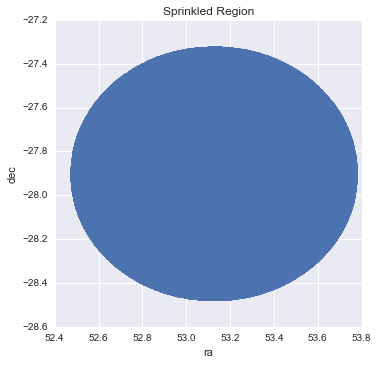

In [28]:
fig, ax = plt.subplots()
ax.plot(np.degrees(TwinkGalsdf.raJ2000.values), np.degrees(TwinkGalsdf.decJ2000.values), 'o')
ax.set_aspect('equal')
ax.set_ylabel('dec')
ax.set_xlabel('ra')
ax.set_title('Sprinkled Region')
fig.savefig('Twinkles_Area.png')

In [29]:
TwinkGalsdf['zbin']= TwinkGalsdf['redshift'] // 0.1
zmids = np.arange(0.05, (TwinkGalsdf.zbin.max()+1.)* 0.1, 0.1)
print(zmids)
zbinnedGals = TwinkGalsdf.groupby('zbin')
binnedTwinks = pd.DataFrame({'zmids': zmids})
binnedTwinks['counts'] = zbinnedGals['redshift'].count()

[  0.05   0.15   0.25   0.35   0.45   0.55   0.65   0.75   0.85   0.95
   1.05   1.15   1.25   1.35   1.45   1.55   1.65   1.75   1.85   1.95
   2.05   2.15   2.25   2.35   2.45   2.55   2.65   2.75   2.85   2.95
   3.05   3.15   3.25   3.35   3.45   3.55   3.65   3.75   3.85   3.95
   4.05   4.15   4.25   4.35   4.45   4.55   4.65   4.75   4.85   4.95
   5.05   5.15   5.25   5.35   5.45   5.55   5.65   5.75   5.85   5.95
   6.05   6.15   6.25   6.35   6.45   6.55   6.65   6.75   6.85   6.95
   7.05   7.15   7.25   7.35   7.45   7.55   7.65   7.75   7.85   7.95
   8.05   8.15   8.25   8.35   8.45   8.55   8.65   8.75   8.85   8.95
   9.05   9.15   9.25   9.35   9.45   9.55   9.65   9.75   9.85   9.95
  10.05  10.15  10.25  10.35  10.45  10.55  10.65  10.75  10.85  10.95
  11.05  11.15  11.25  11.35]


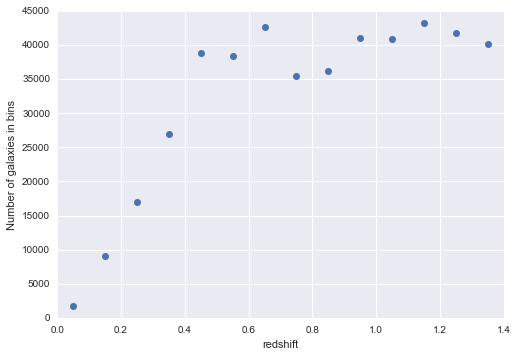

In [30]:
fig, ax = plt.subplots()
ax.errorbar(binnedTwinks.zmids, binnedTwinks.counts, np.sqrt(binnedTwinks.counts), fmt='o' )
ax.set_xlim(0., 1.4)
ax.set_xlabel('redshift')
ax.set_ylabel('Number of galaxies in bins')

## SN light Curves

In [31]:
import sncosmo
import gedankenLSST

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116417890>]], dtype=object)

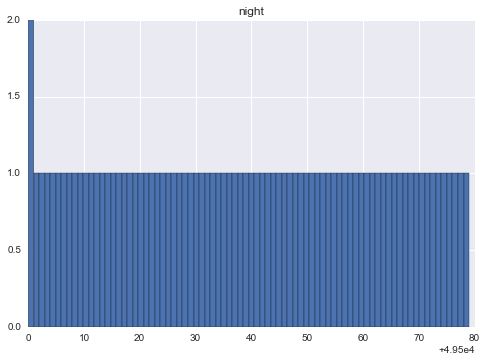

In [32]:
lsstchar = gedankenLSST.LSSTReq
lsstchar['meanNumVisits'] = pd.Series(np.repeat(3650.,6), index=['u','g','r','i','z','y'])
lsstchar['meanNumVisits']
sn = gedankenLSST.GSN_Obs(mjd_center=49530., lsstrequirements=lsstchar)
sndf = sn.summary
sndf[sndf['filter'] == 'u'].hist('night',bins=80)

In [33]:
lsstchar['medianSVD']

u    23.9
g    25.0
r    24.7
i    24.0
z    23.3
y    22.1
dtype: float64

In [34]:
s = gedankenLSST.SNObs(summarydf=sndf, t0=49530, lsst_bp=lsst_bp, ra=centralRA, dec=centralDec)

In [35]:
a = []
for z in binnedTwinks.zmids.values[:12]:
    s.snState = {'z': z}
    lc = s.lightcurve
    totalEpochs = len(lc)
    highSNRlc = lc.query('SNR > 5')
    highSNREpochs = len(highSNRlc)
    highSNREpochs_u = len(highSNRlc.query("filter == 'u'"))
    highSNREpochs_g = len(highSNRlc.query("filter == 'g'"))
    highSNREpochs_r = len(highSNRlc.query("filter == 'r'"))
    highSNREpochs_i = len(highSNRlc.query("filter == 'i'"))
    highSNREpochs_z = len(highSNRlc.query("filter == 'z'"))
    highSNREpochs_y = len(highSNRlc.query("filter == 'y'"))
    
    a.append([z, highSNREpochs, highSNREpochs_u, highSNREpochs_g, highSNREpochs_r, highSNREpochs_i, highSNREpochs_z,
              highSNREpochs_y, totalEpochs, -2.5 * np.log10(s.SN.get('x0'))])

426
438
450
462
474
480
480
480
480
480
480
480


/Users/rbiswas/.local/lib/python2.7/site-packages/gedankenLSST/sninLSST.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['SNR'] = df['flux'] / df['fluxerr']


In [36]:
FlatzSummary  = pd.DataFrame(a, columns=['redshift', 'highSNREpochs', 'u', 'g', 'r', 'i', 'z', 'y', 'totalEpochs', 'mB'])

In [37]:
FlatzSummary['frac'] = FlatzSummary.highSNREpochs / FlatzSummary.totalEpochs

In [38]:
numSNperZBinDesired = NumHighSNdesired /12.
FlatzSummary['NumSNperzBin'] = numSNperZBinDesired * 3650. / 80. / FlatzSummary['frac']

In [39]:
_nsn = FlatzSummary.NumSNperzBin.replace([-np.inf, np.inf], 0.) * FlatzSummary.frac
print(_nsn.sum() * 80. / 3650.) 

2945.24311274


In [40]:
# Increase the numbers since some of the bins are empty

In [41]:
FlatzSummary['NumSNperzBin'] =  FlatzSummary['NumSNperzBin'] * (12./9.)

In [42]:
_nsn = FlatzSummary.NumSNperzBin.replace([-np.inf, np.inf], 0.) * FlatzSummary.frac
print(_nsn.sum() * 80. / 3650.) 

3926.99081699


In [43]:
FlatzSummary['numGalsperzBin'] = binnedTwinks['counts'].head(12)

In [44]:
FlatzSummary['numSNperGal'] = FlatzSummary['NumSNperzBin'] / FlatzSummary['numGalsperzBin'] 

In [45]:
FlatzSummary

,redshift,highSNREpochs,u,g,r,i,z,y,totalEpochs,mB,frac,NumSNperzBin,numGalsperzBin,numSNperGal
0,0.05,409,66,70,70,70,66,67,416,6.956935,0.983173,2.024838e+04,1660,12.197819
1,0.15,378,39,68,70,69,68,64,424,9.490474,0.891509,2.233029e+04,9044,2.469072
2,0.25,312,18,69,70,69,68,18,436,10.728750,0.715596,2.781968e+04,17027,1.633857
3,0.35,254,0,52,70,69,63,0,438,11.572595,0.579909,3.432896e+04,27019,1.270549
4,0.45,201,0,38,59,62,42,0,443,12.218191,0.453725,4.387609e+04,38772,1.131644
5,0.55,148,0,24,48,46,30,0,445,12.742532,0.332584,5.985750e+04,38454,1.556600
6,0.65,87,0,0,41,36,10,0,448,13.184282,0.194196,1.025130e+05,42574,2.407878
7,0.75,60,0,0,28,32,0,0,452,13.565828,0.132743,1.499711e+05,35424,4.233600
8,0.85,28,0,0,10,18,0,0,444,13.901397,0.063063,3.156786e+05,36190,8.722814
9,0.95,0,0,0,0,0,0,0,432,14.200651,0.000000,inf,41037,inf


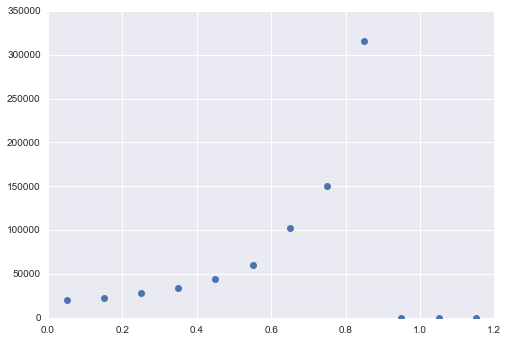

In [46]:
plt.plot(FlatzSummary.redshift, FlatzSummary['NumSNperzBin'].replace(np.inf,0), 'o')

#  SN Table

In [47]:
model = sncosmo.Model(source='salt2')

In [48]:
from astropy.cosmology import FlatLambdaCDM

### Simulation Parameters

In [49]:
# Astropy cosmology object for CatSim Cosmology
CatSimCosmo = FlatLambdaCDM(Om0=0.25, H0=73.)

alphaTwinkles = 0.11
betaTwinkles = -3.14
cdistTwinkles = [0., 0.1]
x1distTwinkles = [0, 1.]
MTwinkles = [-19.3, 0.15]


In [50]:
zbinnedGals = TwinkGalsdf.groupby('zbin')

In [51]:
def assignIds(snwithHosts, maxval=100000000 * 10000 * 100):
    snwithHosts['offset'] = 0
    sngroups = snwithHosts.groupby('galtileid')
    for host in (sngroups.count() > 0).index.values:
        sn = sngroups.get_group(host)
        idx  = sn.index
        snwithHosts.loc[idx, 'offset'] = np.arange(len(sn))
    return None

In [52]:
def assignSNHosts(galdf, numSN, seed):
    if seed is not None:
        np.random.seed(seed)
    sngalids = np.random.choice(galdf.index.values, numSN, replace=True)
    zvals = galdf.ix[sngalids,'redshift']
    df = pd.DataFrame({'galtileid': sngalids, 
                      'redshift' : zvals.values})
    return df

In [53]:
# Slow step: Takes about 20 mins
def assignSN(zbinnedGals, SNzSummary, binList=[0, 1], maxval=100000000 * 10000 * 100, seed=42):
    
    dfs = []
    for idx in binList:
        galdf = zbinnedGals.get_group(idx)
        numSN = SNzSummary.NumSNperzBin[idx]
        if idx == 0 :
            snWithHosts = assignSNHosts(galdf, numSN, seed)
        else:
            snWithHosts = assignSNHosts(galdf, numSN, seed=None)
        assignIds(snWithHosts, maxval=maxval)
        dfs.append(snWithHosts)
    snvals = pd.concat(dfs)
    snvals['snid'] = snvals['galtileid'] *100 + snvals['offset']
    return snvals

In [54]:
# Slow step ~ 20 mins
snvals = assignSN(zbinnedGals, FlatzSummary, binList=[0, 1, 2, 3, 4, 5, 6, 7, 8])

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [55]:
import time 
print time.time()

1454566247.63


In [56]:
snvals.set_index(snvals['snid'], drop=True, verify_integrity=True, inplace=True)

In [57]:
def assigSNParams(sntable, seed=42, cosmo=None, T0Min=0., T0Max=3650., 
                  MabsScatter= [-19.3, 0.15], cScatter=[0., 0.1], x1Scatter=[0., 1.], alpha=0.11, beta=-3.14 ):
    if seed is not None:
        np.random.seed(seed)
        
    model = sncosmo.Model(source='salt2')
    if cosmo is None:
        cosmo = FlatLambdaCDM(Om0=0.25, H0=73.)
        
    numSN = len(sntable)
    zvals = sntable.redshift.values
    cvals = np.random.normal(cScatter[0], cScatter[1], size=numSN)
    x1vals = np.random.normal(x1Scatter[0], x1Scatter[1], size=numSN)
    M  = np.random.normal(MabsScatter[0], MabsScatter[1], size=numSN)
    
    M += -alpha * x1vals - beta * cvals 
    t0 = np.random.uniform(T0Min, T0Max, size=numSN)
    x0 = np.zeros(numSN)
    mB = np.zeros(numSN)
    # Slow Step
    for i, Mabs in enumerate(M):
        model.set(z=zvals[i], c=cvals[i], x1=x1vals[i])
        model.set_source_peakabsmag(Mabs, 'bessellB', 'ab', cosmo=cosmo)
        x0[i] = model.get('x0')
        mB[i] = model.source.peakmag('bessellB', 'ab')
    sntable['t0'] = t0
    sntable['c'] = cvals
    sntable['x1'] = x1vals
    sntable['x0'] = x0
    sntable['mB'] = mB
    sntable['M'] = M
    
    print (alpha, beta, cScatter, x1Scatter, MabsScatter)
    

In [58]:
starttime = time.time()
assigSNParams(sntable=snvals, cosmo=CatSimCosmo, alpha=alphaTwinkles, beta=betaTwinkles, MabsScatter=MTwinkles, 
              seed=24)
endtime = time.time()
print("Time taken", endtime - starttime)

KeyboardInterrupt: 

In [ ]:
def assignPositions(sntable, Galsdf, seed=42):

    radiansPerArcSec = (np.pi / 180.)* (1./60.)**2
    if seed is not None:
        np.random.seed(seed)
    
    r1 = np.random.normal(0., 1., sntable.snid.size)
    r2 = np.random.normal(0., 1., sntable.snid.size)
    
    sntable['raJ2000'] = Galsdf.ix[sntable.galtileid, 'raJ2000'].values
    sntable['decJ2000'] = Galsdf.ix[sntable.galtileid, 'decJ2000'].values
    sntable['a_d'] = Galsdf.ix[sntable.galtileid, 'a_d'].values * radiansPerArcSec
    sntable['b_d'] = Galsdf.ix[sntable.galtileid, 'b_d'].values * radiansPerArcSec

    # convert from degrees to radians
    sntable['theta'] = np.radians(Galsdf.ix[sntable.galtileid, 'pa_disk'].values)
    
    sntable['sndec'] = np.cos(-sntable['theta']) * sntable['a_d']* r1 + np.sin(-sntable['theta'])*sntable['b_d'] * r2
    sntable['snra'] =  - np.sin(-sntable['theta']) * sntable['a_d']*r1 + np.cos(-sntable['theta'])* sntable['b_d'] * r2
    sntable['snra'] += Galsdf.ix[sntable.galtileid, 'raJ2000'].values
    sntable['sndec'] += Galsdf.ix[sntable.galtileid, 'decJ2000'].values
    
    sntable['sndec'] = np.degrees(sntable['sndec'])
    sntable['snra'] = np.degrees(sntable['snra'])
    sntable['raJ2000'] = np.degrees(sntable['raJ2000'])
    sntable['decJ2000'] = np.degrees(sntable['decJ2000'])



In [ ]:
assignPositions(snvals, TwinkGalsdf, seed=4 )

In [ ]:
snvals.raJ2000.hist(histtype='step', alpha=1, lw=4, color='k')
snvals.snra.hist(histtype='step', lw=1, color='r')

In [ ]:
(snvals.snra - snvals.raJ2000).hist(histtype='step', lw=1, color='r',bins=50, **{'normed':True, 'log':True})
(snvals.sndec - snvals.decJ2000).hist(histtype='step', lw=1, color='b',bins=50, **{'normed':True, 'log':True})

In [ ]:
plt.hist(snvals.sndec - snvals.decJ2000,histtype='step', lw=1, color='b',bins=50,
        log=True)

In [ ]:
snvals.head()

In [ ]:
snvals.columns

In [ ]:
(snvals.raJ2000.iloc[0] - snvals.snra.iloc[0]) * 180. / np.pi * 3600.

In [ ]:
snvals.head()

In [ ]:
(3600* (snvals.snra - snvals.raJ2000).apply(np.degrees)).hist(bins=20)

In [ ]:
snvals.head()

In [ ]:
snvals.to_csv('TwinklesSN_new.csv')

In [ ]:
#snvals.to_csv('TwinklesSN.csv')

In [ ]:
len(np.unique(snvals.index.values)) == len(snvals.index.values)